In [15]:
import os
from pathlib import Path

cwd = Path.cwd()
if cwd.name == "notebooks":
    os.chdir(cwd.parent)

In [16]:
import pandas as pd
from mllm_emotion_classifier.utils import (
    add_fairness_metrics_by_emotion,
    add_fairness_metrics_by_emotion,
    plot_fairness_vs_hparam,
    plot_fairness_by_emotion,
    FigureCollector,
)
from EmoBox.EmoBox import EmoDataset

In [17]:
hparam = 'top_p' # or 'top_p'
assert hparam in ['temperature', 'top_p'], "hparam must be either 'temperature' or 'top_p'"

dataset = 'cremad'
fold = None # Set to an integer fold number if needed, else None to aggregate all folds
sensitive_attr = 'gender' # gender, age, ethnicity, race
model = 'qwen2-audio-instruct'

metadata_dir = Path('EmoBox/data/')
dataset_path = metadata_dir / dataset
n_folds = len([d for d in dataset_path.iterdir() if d.is_dir() and d.name.startswith("fold_")])
out_dir = Path('outputs') / "temperature_runs" if hparam == 'temperature' else Path('outputs') / "topp_runs"

test = EmoDataset(dataset, './', metadata_dir, fold=1, split="test")
emotions = set(test.label_map.values())

if fold is None:
    dfs = []
    for f in range(1, n_folds + 1):
        results_csv = out_dir / model / dataset / f'fold_{f}.csv'
        df_fold = pd.read_csv(results_csv)
        dfs.append(df_fold)
    df = pd.concat(dfs, ignore_index=True)
else:
    results_csv = out_dir / model / dataset / f'fold_{fold}.csv'
    df = pd.read_csv(results_csv)

print(len(df), "rows")
df.head(5)

since there is no official valid data, use random split for train valid split, with a ratio of [80, 20]
load in 5586 samples, only 5586 exists in data dir EmoBox/data
load in 1856 samples, only 1856 exists in data dir EmoBox/data
Num. training samples 5586
Num. valid samples 0
Num. test samples 1856
Using label_map {'ANG': 'Angry', 'DIS': 'Disgust', 'FEA': 'Fear', 'HAP': 'Happy', 'NEU': 'Neutral', 'SAD': 'Sad'}
50 rows


,run,dataset,fold,model,prompt,top_p,valid_rate,global_f1_macro,global_f1_weighted,global_accuracy_unweighted,...,language_English_classwise_negative_predictive_value_Fear,language_English_classwise_negative_predictive_value_Happy,language_English_classwise_negative_predictive_value_Neutral,language_English_classwise_negative_predictive_value_Sad,language_English_classwise_f1_score_Angry,language_English_classwise_f1_score_Disgust,language_English_classwise_f1_score_Fear,language_English_classwise_f1_score_Happy,language_English_classwise_f1_score_Neutral,language_English_classwise_f1_score_Sad
0,0,cremad,1,qwen2-audio-instruct,user_labels,0.0001,1.0,0.7049,0.7007,0.7233,...,0.8879,0.9742,0.9909,0.9880,0.8817,0.4208,0.5553,0.8935,0.8771,0.6012
1,0,cremad,1,qwen2-audio-instruct,user_labels,0.3000,1.0,0.6963,0.6924,0.7003,...,0.8766,0.9665,0.9742,0.9916,0.8991,0.4895,0.4787,0.8964,0.8534,0.5605
2,0,cremad,1,qwen2-audio-instruct,user_labels,0.5000,1.0,0.7422,0.7393,0.7437,...,0.8888,0.9665,0.9833,0.9865,0.8980,0.6307,0.5593,0.8949,0.8596,0.6105
3,0,cremad,1,qwen2-audio-instruct,user_labels,0.7000,1.0,0.7335,0.7307,0.7421,...,0.9087,0.9716,0.9901,0.9804,0.8824,0.5070,0.6694,0.8778,0.8449,0.6195
4,0,cremad,1,qwen2-audio-instruct,user_labels,1.0000,1.0,0.6405,0.7466,0.7433,...,0.9166,0.9586,0.9649,0.9423,0.9017,0.6895,0.6367,0.8700,0.7714,0.6138


In [18]:
emotions

{'Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad'}

In [19]:
run = None
df = add_fairness_metrics_by_emotion(df, emotions, sensitive_attr=sensitive_attr, fairness_name='statistical_parity', run=run)
df = add_fairness_metrics_by_emotion(df, emotions, sensitive_attr=sensitive_attr, fairness_name='equal_opportunity', run=run)
df = add_fairness_metrics_by_emotion(df, emotions, sensitive_attr=sensitive_attr, fairness_name='equal_non_opportunity', run=run)
df = add_fairness_metrics_by_emotion(df, emotions, sensitive_attr=sensitive_attr, fairness_name='predictive_parity', run=run)
df = add_fairness_metrics_by_emotion(df, emotions, sensitive_attr=sensitive_attr, fairness_name='negative_predictive_parity', run=run)

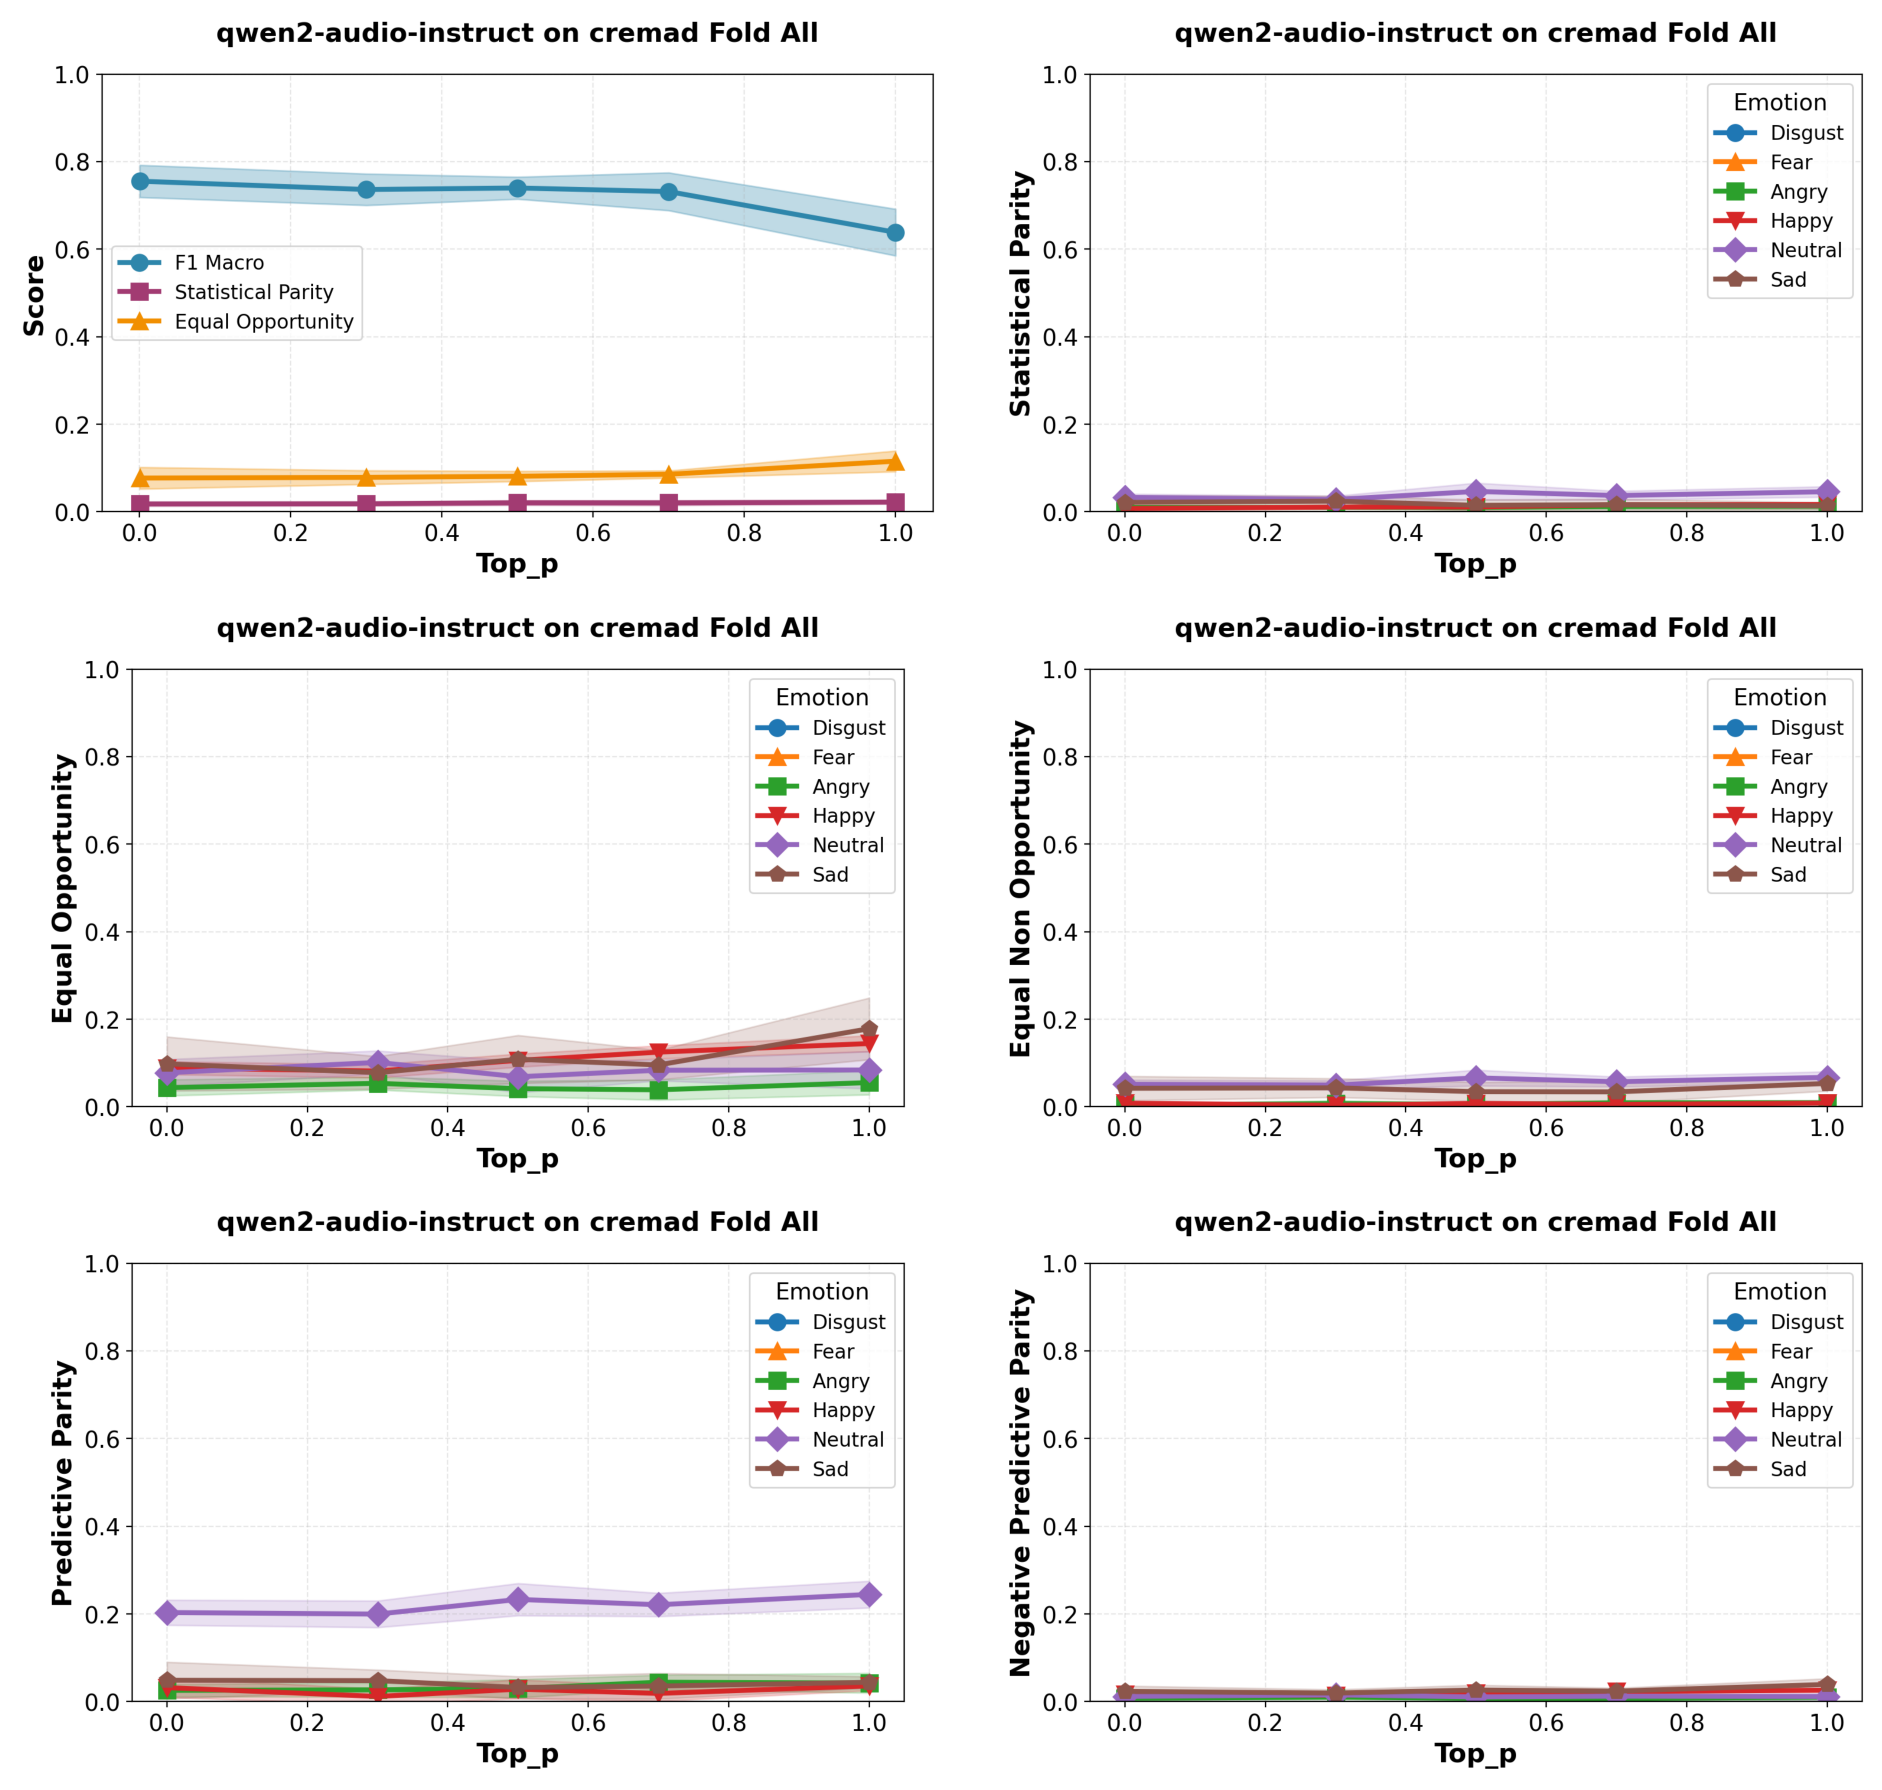

In [20]:
show_std = True
with FigureCollector() as collector:
    plot_fairness_vs_hparam(df, hparam, ['statistical_parity', 'equal_opportunity'], model, dataset, fold, show_std=show_std)
    plot_fairness_by_emotion(df, emotions, hparam, 'statistical_parity', model, dataset, fold, show_std=show_std)
    plot_fairness_by_emotion(df, emotions, hparam, 'equal_opportunity', model, dataset, fold, show_std=show_std)
    plot_fairness_by_emotion(df, emotions, hparam, 'equal_non_opportunity', model, dataset, fold, show_std=show_std)
    plot_fairness_by_emotion(df, emotions, hparam, 'predictive_parity', model, dataset, fold, show_std=show_std)
    plot_fairness_by_emotion(df, emotions, hparam, 'negative_predictive_parity', model, dataset, fold, show_std=show_std)
    
collector.display_grid(nrows=3, ncols=2, figsize=(20, 18))
        # , title=f'Fairness Metrics by Emotion - {model} on {dataset} Fold {fold}')

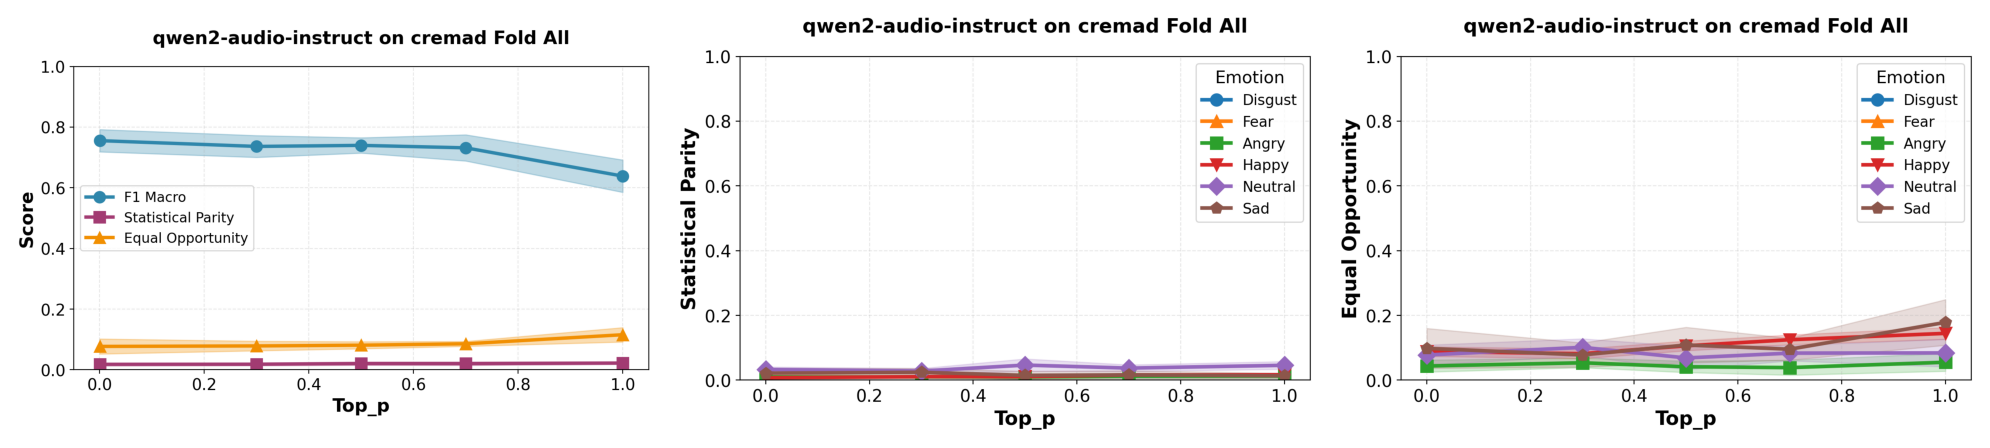

In [21]:
show_std = True
with FigureCollector() as collector:
    plot_fairness_vs_hparam(df, hparam, ['statistical_parity', 'equal_opportunity'], model, dataset, fold, show_std=show_std)
    plot_fairness_by_emotion(df, emotions, hparam, 'statistical_parity', model, dataset, fold, show_std=show_std)
    plot_fairness_by_emotion(df, emotions, hparam, 'equal_opportunity', model, dataset, fold, show_std=show_std)
    
collector.display_grid(nrows=1, ncols=3, figsize=(20, 18))